In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as tc
#from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
class Morphism(nn.Module):
    def __init__ (self, name = 'Morphisme R^n --> E', dim_E = 1, neurons = 6):
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(Morphism, self).__init__()
        # layers for plus : E --> E
        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)

        # dropout layer
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = self.fc4(x)
        return output

In [3]:
class InverseMorphism(nn.Module):
    def __init__ (self, name = 'Inverse E --> R^n', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(InverseMorphism, self).__init__()
        # layers for plus : E --> E
        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3= nn.Linear(neurons, neurons)
        
        self.fc4 = nn.Linear(neurons, dim_E)
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        output = self.fc4(x)
        return output

In [4]:
class LoiBinaire(nn.Module):
    def __init__ (self, name = 'Loi binaire ExE-->E', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(LoiBinaire, self).__init__()
        # layers for plus : ExE --> E
        self.fc1 = nn.Linear(2 * dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)
    def forward(self, x, y):
        z = torch.cat([x,y], axis=1) # [K,d], [K,d] ---> [K, 2*d]
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        output = self.fc4(z)
        return output
# scalaire product of structure

In [5]:
class LoiScalaire(nn.Module):
    def __init__ (self, name = 'Loi Scalaire RxE-->E', dim_E = 1, neurons = 6):
        
        print(f'[Model] name : {name}')
        print(f'[Model] dim E : {dim_E}')
        print(f'[Model] no. neurons per layers : {neurons}')
        super(LoiScalaire, self).__init__()
        # layers for scaler : KxE --> E
        

        self.fc1 = nn.Linear(dim_E, neurons)
        self.fc2 = nn.Linear(neurons, neurons)
        self.fc3 = nn.Linear(neurons, neurons)
        self.fc4 = nn.Linear(neurons, dim_E)
        
        # alpha est un  scalaire,  dim_E est la dimension de l'espace E
        
    def forward(self, alpha, x):
        z = alpha * x # [K,1], [K,d] ---> [K, d]
        z = self.fc1(z)
        z = self.fc2(z)
        z = self.fc3(z)
        output = self.fc4(z)
        return output

In [6]:
class Vect_space(nn.Module):
    def __init__ (self, K,  dim_E = 1 , neurons = 6 , name = 'Groupe (E,+)'):
        super(Vect_space, self).__init__()
        self.f    = Morphism(dim_E = dim_E, neurons = neurons)
        self.fi   = InverseMorphism(dim_E = dim_E, neurons = neurons)
        self.plus = LoiBinaire(dim_E = dim_E, neurons = neurons)
        self.scalaire = LoiScalaire(dim_E = dim_E, neurons = neurons)
        # losses
        self.loss_1 = lambda x, y : torch.linalg.vector_norm(self.plus(x , y) - self.f( self.fi(x) + self.fi(y)) )**2
        self.loss_2 = lambda alpha, x : torch.linalg.vector_norm(self.scalaire(alpha , x) - self.f( alpha*self.fi(x)) )**2

        #  Total loss can be weighted 
        self.loss = lambda x, y, alpha : self.loss_1(x, y) + self.loss_2(alpha, x)
        
    def train(self, X, Y,alpha, optimizer, epoch):
        self.f.train()
        self.fi.train()
        self.plus.train()
        self.scalaire.train()
        losses=[]
        for i in range(epoch):
            L1 = self.loss_1(X, Y)
            L2 = self.loss_2(alpha, X)
            loss = L1 + L2
            #loss = loss.mean()
            if i % 200 == 0:
               print('Epoch {}/{} -\t Loss 1: {:.6f}\t Loss 2: {:.6f}\t Total Loss: {:.6f}'.format(i, epoch, L1.item(), L2.item(), loss.item()))
            
            loss.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        return losses

In [7]:
def line(K, epsilon):
    X = torch.rand(K, 2).requires_grad_(False)
    X[K//2:] *= -1
    Y = torch.randn(K, 2).requires_grad_(False)
    Y[K//2:] *= -1
    alpha = torch.randn(K, 1).requires_grad_(False)
    X[:,1] = X[:,0] + epsilon * torch.sin(X[:,0] / epsilon)
    Y[:,1] = Y[:,0] + epsilon * torch.sin(Y[:,0] / epsilon)
    return X, Y, alpha

[Model] name : Morphisme R^n --> E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Inverse E --> R^n
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi binaire ExE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi Scalaire RxE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
Epoch 0/1000 -	 Loss 1: 115.949532	 Loss 2: 7.144033	 Total Loss: 123.093567
Epoch 200/1000 -	 Loss 1: 24.414928	 Loss 2: 0.224367	 Total Loss: 24.639296
Epoch 400/1000 -	 Loss 1: 0.946390	 Loss 2: 0.143054	 Total Loss: 1.089444
Epoch 600/1000 -	 Loss 1: 0.047986	 Loss 2: 0.045491	 Total Loss: 0.093477
Epoch 800/1000 -	 Loss 1: 0.033065	 Loss 2: 0.031494	 Total Loss: 0.064559


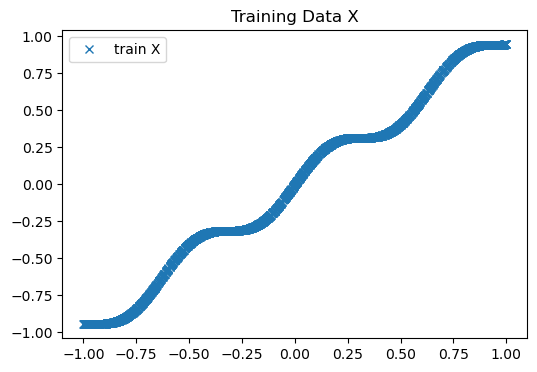

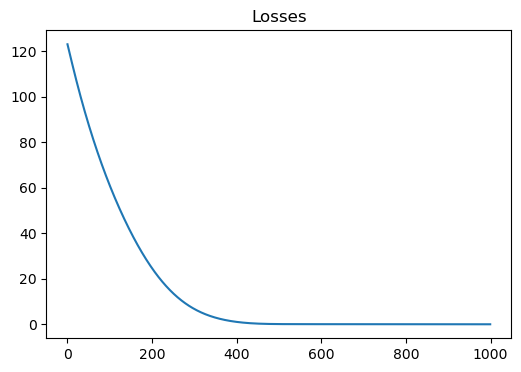

In [8]:
K = 2000
epislon = 0.1
X,Y,alpha = line(K, epislon)
dim = 2

# on initialise le vecteur space
G = Vect_space(K, dim_E = dim, neurons = 64)
# on initialise l'optimiseur

optimizer = optim.Adadelta(list(G.parameters()), lr=1e-3)
# la loss
losses = G.train(X,Y, alpha, optimizer, 1000)

plt.figure(figsize=(6, 4))
plt.plot(X[:,0], X[:,1], 'x', label='train X')
plt.title('Training Data X')
plt.legend()
plt.show()



# on affiche la loss 
plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title('Losses')
plt.show()

In [9]:
K = 10
B = 0.3*torch.randn((K, 2))
C = 0.3*torch.randn((K, 2))
alpha = torch.randn((K, 1))

# Générer une valeur aléatoire pour B[0,0]
for i in range(K):
    B[i,1] = B[i,0] + epislon * torch.sin(B[i,0] / epislon )
    C[i,1] = C[i,0] + epislon * torch.sin(C[i,0] / epislon )



    
print(B)

print(C)


tensor([[ 0.2395,  0.3074],
        [-0.0312, -0.0618],
        [-0.0219, -0.0437],
        [-0.0922, -0.1718],
        [ 0.4010,  0.3247],
        [ 0.3353,  0.3143],
        [-0.1520, -0.2518],
        [-0.1703, -0.2694],
        [-0.1113, -0.2010],
        [-0.2824, -0.3136]])
tensor([[-0.0135, -0.0270],
        [ 0.0294,  0.0584],
        [ 0.1286,  0.2246],
        [-0.3686, -0.3168],
        [ 0.2542,  0.3106],
        [-0.5423, -0.4665],
        [ 0.0525,  0.1026],
        [-0.1800, -0.2774],
        [-0.2348, -0.3061],
        [-0.3221, -0.3142]])


In [10]:
import pandas as pd
# Convert B and C to numpy arrays
# Convert B and C to numpy arrays
B_np = B.numpy()
C_np = C.numpy()
alpha_np = alpha.numpy()

# Create a DataFrame
df = pd.DataFrame({
    'B_x': B_np[:, 0],
    'B_y': B_np[:, 1],
    'C_x': C_np[:, 0],
    'C_y': C_np[:, 1],
    'alpha': alpha_np[:, 0]
})

print(df)



        B_x       B_y       C_x       C_y     alpha
0  0.239456  0.307402 -0.013537 -0.027032 -1.088488
1 -0.031158 -0.061815  0.029432  0.058440 -1.090422
2 -0.021922 -0.043668  0.128590  0.224559  0.149240
3 -0.092152 -0.171804 -0.368641 -0.316815  1.818311
4  0.401004  0.324671  0.254235  0.310637 -2.093857
5  0.335339  0.314317 -0.542322 -0.466541  0.097072
6 -0.151969 -0.251838  0.052477  0.102579 -0.416804
7 -0.170315 -0.269440 -0.179966 -0.277358 -0.772718
8 -0.111321 -0.201033 -0.234793 -0.306086 -0.737101
9 -0.282378 -0.313627 -0.322135 -0.314168 -2.230347


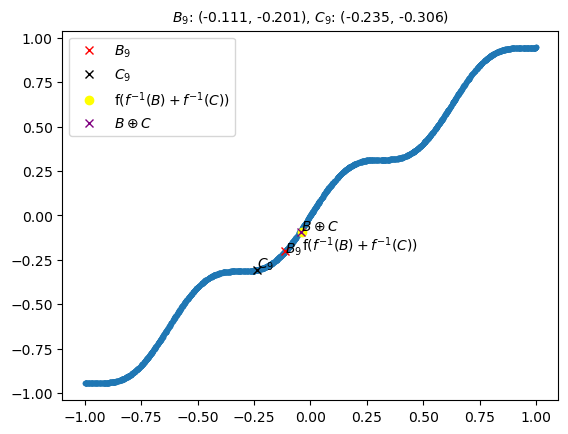

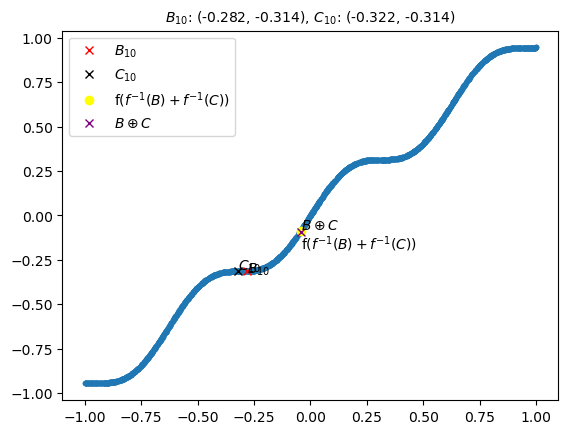

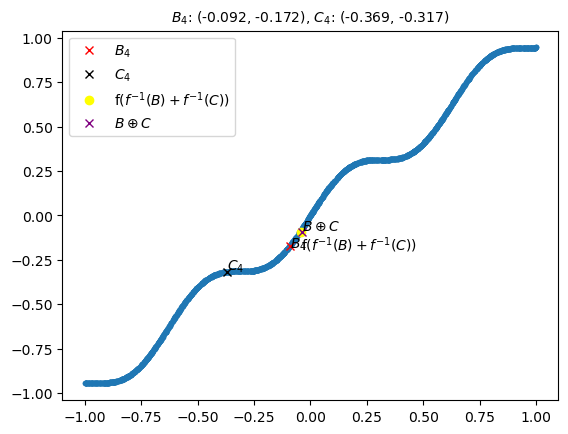

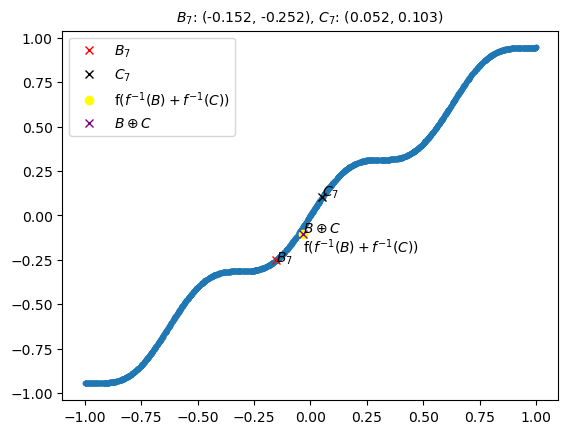

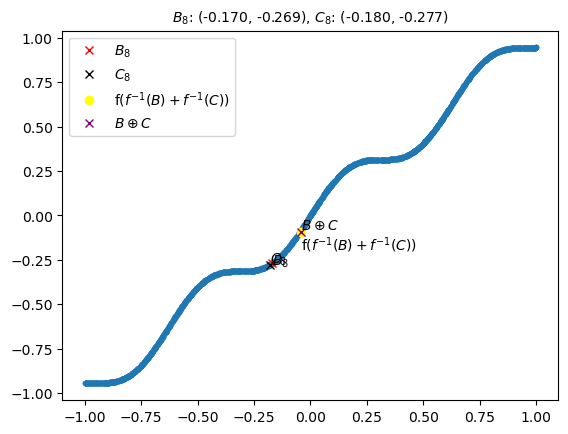

In [11]:
import random
import matplotlib.pyplot as plt
import matplotlib.cm as cm

XXBC =  G.f(G.fi(B) + G.fi(C))
YYBC = G.plus(B, C)

# indice = random.sample(range(B.shape[0]),5)
# for i in indice:
#     plt.figure()
#     plt.scatter(X[:, 0], X[:, 1], color='blue', alpha =  0.05) 
#     plt.scatter(B[i, 0], B[i, 1], color='red', label=f'B_{i+1}')  
#     plt.annotate(f'B_{i+1}', (B[i, 0], B[i, 1] - 0.01))
#     plt.scatter(C[i, 0], C[i, 1], color='green', label=f'C_{i+1}')
#     plt.annotate(f'C_{i+1}', (C[i, 0], C[i, 1] + 0.01))
#     # Tracer le point XXBC[i]
#     plt.scatter(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), color='orange', label=f'f(fi(B) + fi(C))')
#     plt.annotate(f'f(fi(B) + fi(C))', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy() - 0.1))

#     # Tracer le point YYBC[i]
#     plt.scatter(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), color='pink', label=f'B⊕C')
#     plt.annotate(f'B⊕C', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy() + 0.01))
#     # Ajouter une légende au subplot
#     plt.legend()
#     plt.show()



indice = random.sample(range(B.shape[0]),5)
for i in indice:
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], '.', linewidth = 0.01) 
    plt.plot(B[i, 0], B[i, 1],   'x', color='red',  label=r'$B_{' + str(i+1) + '}$')  
    plt.annotate(r'$B_{' + str(i+1) + '}$', (B[i, 0], B[i, 1] - 0.01))
    plt.plot(C[i, 0], C[i, 1], 'x',  color='black', label=r'$C_{' + str(i+1) + '}$', )
    plt.annotate(r'$C_{' + str(i+1) + '}$', (C[i, 0], C[i, 1] + 0.01))
    # Tracer le point XXBC[i]
    plt.plot(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), 'o', color='yellow', label=r'f($f^{-1}(B) + f^{-1}(C)$)')
    plt.annotate(r'f($f^{-1}(B) + f^{-1}(C)$)', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy() - 0.1))

    # Tracer le point YYBC[i]
    plt.plot(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), 'x', color='purple', label=r'$B \oplus C$')
    plt.annotate(r'$B \oplus C$', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy() + 0.01))
    # Ajouter une légende au subplot    

    plt.title(r'$B_{' + str(i+1) + '}$' + f': ({B[i, 0]:.3f}, {B[i, 1]:.3f}), ' + r'$C_{' + str(i+1) + '}$' + f': ({C[i, 0]:.3f}, {C[i, 1]:.3f})', fontsize=10)
    plt.legend()
    plt.show()

In [12]:
XXBC =  G.f(G.fi(B) + G.fi(C))

YYBC = G.plus(B, C)

# print(XXBC)
# print(YYBC)


XXBC_list = [x.detach().numpy() for x in XXBC]
YYBC_list = [y.detach().numpy() for y in YYBC]

# Calculer l'erreur pour chaque couple et la stocker dans une liste
erreur_list_l2 = [torch.norm(XXBC[i] - YYBC[i], p=2).item() for i in range(len(XXBC))]
erreur_list_inf = [torch.norm(XXBC[i] - YYBC[i], p=float('inf')).item() for i in range(len(XXBC))]


# Convertir les erreurs en notation scientifique
erreur_list_l2 = ['{:.1e}'.format(erreur) for erreur in erreur_list_l2]
erreur_list_inf = ['{:.1e}'.format(erreur) for erreur in erreur_list_inf]


# Ajouter les listes comme nouvelles colonnes dans le DataFrame
df['f.fi(B) + f.fi(C)'] = XXBC_list
df['B⊕C'] = YYBC_list
# Ajouter la colonne 'Erreur' à la fin du DataFrame
df['L^2 erreur'] = erreur_list_l2
df['inf erreur'] = erreur_list_inf

df






,B_x,B_y,C_x,C_y,alpha,f.fi(B) + f.fi(C),B⊕C,L^2 erreur,inf erreur
0,0.239456,0.307402,-0.013537,-0.027032,-1.088488,"[-0.028749574, -0.114133485]","[-0.026328396, -0.115747444]",2.9e-03,2.4e-03
1,-0.031158,-0.061815,0.029432,0.058440,-1.090422,"[-0.032715894, -0.10663581]","[-0.030748228, -0.108828425]",2.9e-03,2.2e-03
2,-0.021922,-0.043668,0.128590,0.224559,0.149240,"[-0.030450428, -0.111256406]","[-0.027137268, -0.115747176]",5.6e-03,4.5e-03
3,-0.092152,-0.171804,-0.368641,-0.316815,1.818311,"[-0.040047668, -0.09337423]","[-0.03822719, -0.09550657]",2.8e-03,2.1e-03
4,0.401004,0.324671,0.254235,0.310637,-2.093857,"[-0.022650855, -0.12442306]","[-0.020893058, -0.12747444]",3.5e-03,3.1e-03
5,0.335339,0.314317,-0.542322,-0.466541,0.097072,"[-0.03547185, -0.10216187]","[-0.032498665, -0.10543394]",4.4e-03,3.3e-03
6,-0.151969,-0.251838,0.052477,0.102579,-0.416804,"[-0.034603503, -0.10290237]","[-0.033129666, -0.10523356]",2.8e-03,2.3e-03
7,-0.170315,-0.269440,-0.179966,-0.277358,-0.772718,"[-0.0396243, -0.092827134]","[-0.040845595, -0.09023706]",2.9e-03,2.6e-03
8,-0.111321,-0.201033,-0.234793,-0.306086,-0.737101,"[-0.039287336, -0.09370132]","[-0.039903823, -0.09197234]",1.8e-03,1.7e-03
9,-0.282378,-0.313627,-0.322135,-0.314168,-2.230347,"[-0.04224536, -0.08949466]","[-0.040574282, -0.09059823]",2.0e-03,1.7e-03


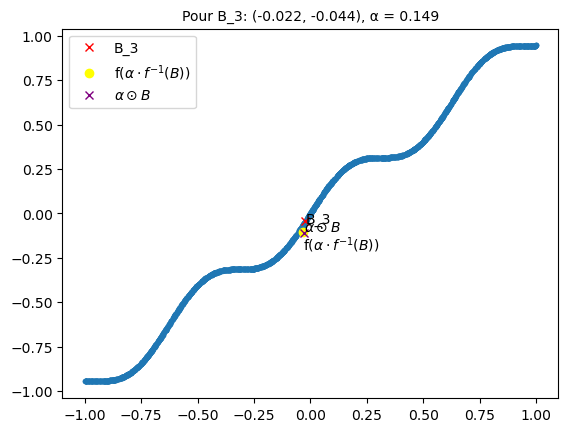

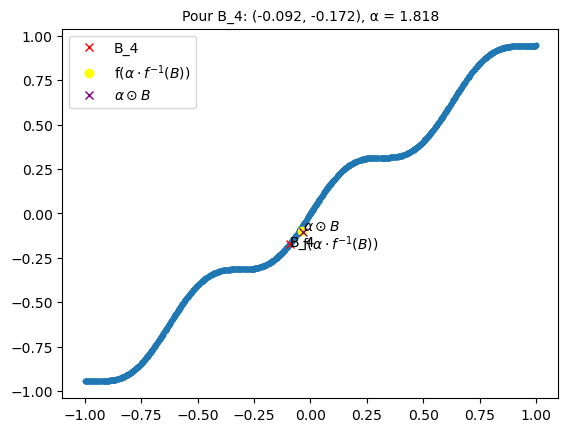

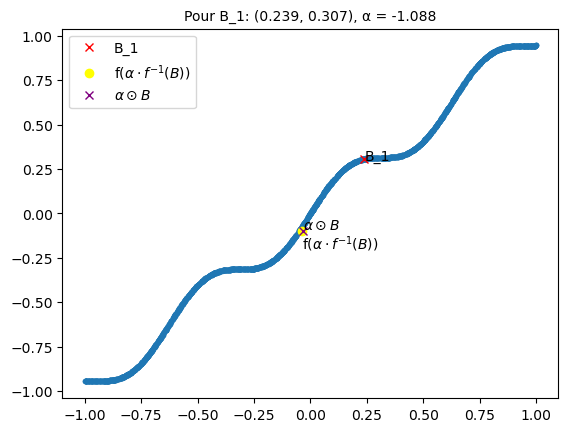

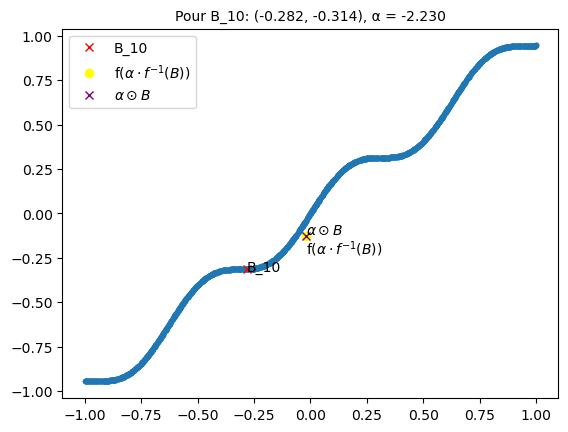

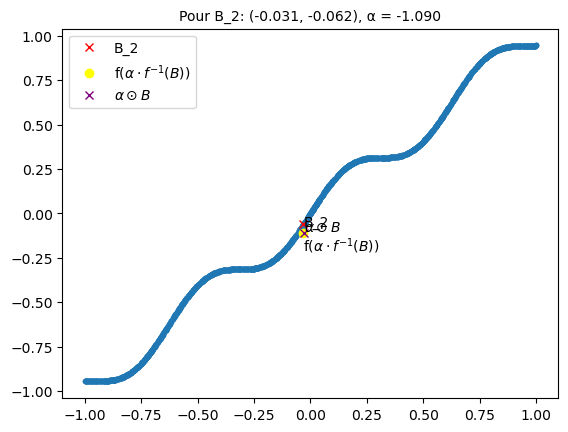

In [13]:

import matplotlib.pyplot as plt
import matplotlib.cm as cm

XXBC =  G.f(alpha * G.fi(B))

YYBC = G.scalaire(alpha, B)
indice = random.sample(range(B.shape[0]),5)
# for i in indice:
#     plt.figure()
#     plt.scatter(X[:, 0], X[:, 1], color='blue', label='X') 
#     plt.scatter(B[i, 0], B[i, 1], color='red', label=f'B_{i+1}')  
#     plt.annotate(f'B_{i+1}', (B[i, 0], B[i, 1]))
#     plt.scatter(C[i, 0], C[i, 1], color='green', label=f'C_{i+1}')
#     plt.annotate(f'C_{i+1}', (C[i, 0], C[i, 1]))
#     # Tracer le point XXBC[i]
#     plt.scatter(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), color='orange', label=f'f(alpha * fi(B)')
#     plt.annotate(f'f( alpha * fi(B))', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy()))

#     # Tracer le point YYBC[i]
#     plt.scatter(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), color='pink', label=f'B⊕C')
#     plt.annotate(f'B⊕C', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy()))
#     # Ajouter une légende au subplot
#     plt.legend()
#     plt.show()





for i in indice:
    plt.figure()
    plt.plot(X[:, 0], X[:, 1], '.', linewidth = 0.01) 
    plt.plot(B[i, 0], B[i, 1],   'x', color='red',  label=f'B_{i+1}')  
    plt.annotate(f'B_{i+1}', (B[i, 0], B[i, 1] - 0.01))
    # Tracer le point XXBC[i]
    plt.plot(XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy(), 'o', color='yellow', label=r'f($\alpha \cdot f^{-1}(B)$)')
    plt.annotate(r'f($\alpha \cdot f^{-1}(B)$)', (XXBC[i, 0].detach().numpy(), XXBC[i, 1].detach().numpy() - 0.1))

    # Tracer le point YYBC[i]
    plt.plot(YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy(), 'x', color='purple', label=r'$\alpha \odot B$')
    plt.annotate(r'$\alpha \odot B$', (YYBC[i, 0].detach().numpy(), YYBC[i, 1].detach().numpy() + 0.01))
    # Ajouter une légende au subplot    
    plt.title(f'Pour B_{i+1}: ({B[i, 0].item():.3f}, {B[i, 1].item():.3f}), α = {alpha[i].item():.3f}', fontsize=10)
    plt.legend()
    plt.show()

In [14]:
XXBC =  G.f(alpha *G.fi(B))

YYBC = G.scalaire(alpha, B)

# print(XXBC)
# print(YYBC)


XXBC_list = [x.detach().numpy() for x in XXBC]
YYBC_list = [y.detach().numpy() for y in YYBC]

# Calculer l'erreur pour chaque couple et la stocker dans une liste
erreur_list_l2 = [torch.norm(XXBC[i] - YYBC[i], p=2).item() for i in range(len(XXBC))]
erreur_list_inf = [torch.norm(XXBC[i] - YYBC[i], p=float('inf')).item() for i in range(len(XXBC))]


# Convertir les erreurs en notation scientifique
erreur_list_l2 = ['{:.1e}'.format(erreur) for erreur in erreur_list_l2]
erreur_list_inf = ['{:.1e}'.format(erreur) for erreur in erreur_list_inf]


# Ajouter les listes comme nouvelles colonnes dans le DataFrame
df['f(alpha . fi(B))'] = XXBC_list
df['B⊙C'] = YYBC_list
# Ajouter la colonne 'Erreur' à la fin du DataFrame
df['L^2 erreur'] = erreur_list_l2
df['inf erreur'] = erreur_list_inf

df






,B_x,B_y,C_x,C_y,alpha,f.fi(B) + f.fi(C),B⊕C,L^2 erreur,inf erreur,f(alpha . fi(B)),B⊙C
0,0.239456,0.307402,-0.013537,-0.027032,-1.088488,"[-0.028749574, -0.114133485]","[-0.026328396, -0.115747444]",4.2e-03,3.1e-03,"[-0.03676305, -0.09801675]","[-0.033629164, -0.10080997]"
1,-0.031158,-0.061815,0.029432,0.058440,-1.090422,"[-0.032715894, -0.10663581]","[-0.030748228, -0.108828425]",1.7e-03,1.5e-03,"[-0.03136275, -0.10846373]","[-0.02987849, -0.10930389]"
2,-0.021922,-0.043668,0.128590,0.224559,0.149240,"[-0.030450428, -0.111256406]","[-0.027137268, -0.115747176]",2.9e-03,2.4e-03,"[-0.032434985, -0.10661308]","[-0.030082151, -0.10825929]"
3,-0.092152,-0.171804,-0.368641,-0.316815,1.818311,"[-0.040047668, -0.09337423]","[-0.03822719, -0.09550657]",6.9e-03,5.1e-03,"[-0.036358595, -0.09899269]","[-0.03121671, -0.103626184]"
4,0.401004,0.324671,0.254235,0.310637,-2.093857,"[-0.022650855, -0.12442306]","[-0.020893058, -0.12747444]",4.2e-03,3.5e-03,"[-0.043792415, -0.087021545]","[-0.046210073, -0.083554596]"
5,0.335339,0.314317,-0.542322,-0.466541,0.097072,"[-0.03547185, -0.10216187]","[-0.032498665, -0.10543394]",2.9e-03,2.4e-03,"[-0.031860303, -0.10763157]","[-0.02948729, -0.10930711]"
6,-0.151969,-0.251838,0.052477,0.102579,-0.416804,"[-0.034603503, -0.10290237]","[-0.033129666, -0.10523356]",1.7e-03,1.5e-03,"[-0.030959222, -0.1094317]","[-0.02947528, -0.11015366]"
7,-0.170315,-0.269440,-0.179966,-0.277358,-0.772718,"[-0.0396243, -0.092827134]","[-0.040845595, -0.09023706]",8.5e-04,8.5e-04,"[-0.029569704, -0.11207828]","[-0.028724402, -0.112109]"
8,-0.111321,-0.201033,-0.234793,-0.306086,-0.737101,"[-0.039287336, -0.09370132]","[-0.039903823, -0.09197234]",1.0e-03,9.8e-04,"[-0.030425766, -0.110482454]","[-0.02944412, -0.11067082]"
9,-0.282378,-0.313627,-0.322135,-0.314168,-2.230347,"[-0.04224536, -0.08949466]","[-0.040574282, -0.09059823]",1.7e-03,1.5e-03,"[-0.021633886, -0.12575832]","[-0.02017457, -0.1267104]"


In [15]:
frame = df[['B_x', 'B_y', 'L^2 erreur', 'inf erreur', 'B⊙C', 'f(alpha . fi(B))']]


frame = df[['B_x', 'B_y', 'B⊙C', 'f(alpha . fi(B))', 'L^2 erreur', 'inf erreur']]

frame


,B_x,B_y,B⊙C,f(alpha . fi(B)),L^2 erreur,inf erreur
0,0.239456,0.307402,"[-0.033629164, -0.10080997]","[-0.03676305, -0.09801675]",4.2e-03,3.1e-03
1,-0.031158,-0.061815,"[-0.02987849, -0.10930389]","[-0.03136275, -0.10846373]",1.7e-03,1.5e-03
2,-0.021922,-0.043668,"[-0.030082151, -0.10825929]","[-0.032434985, -0.10661308]",2.9e-03,2.4e-03
3,-0.092152,-0.171804,"[-0.03121671, -0.103626184]","[-0.036358595, -0.09899269]",6.9e-03,5.1e-03
4,0.401004,0.324671,"[-0.046210073, -0.083554596]","[-0.043792415, -0.087021545]",4.2e-03,3.5e-03
5,0.335339,0.314317,"[-0.02948729, -0.10930711]","[-0.031860303, -0.10763157]",2.9e-03,2.4e-03
6,-0.151969,-0.251838,"[-0.02947528, -0.11015366]","[-0.030959222, -0.1094317]",1.7e-03,1.5e-03
7,-0.170315,-0.269440,"[-0.028724402, -0.112109]","[-0.029569704, -0.11207828]",8.5e-04,8.5e-04
8,-0.111321,-0.201033,"[-0.02944412, -0.11067082]","[-0.030425766, -0.110482454]",1.0e-03,9.8e-04
9,-0.282378,-0.313627,"[-0.02017457, -0.1267104]","[-0.021633886, -0.12575832]",1.7e-03,1.5e-03


[Model] name : Morphisme R^n --> E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Inverse E --> R^n
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi binaire ExE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
[Model] name : Loi Scalaire RxE-->E
[Model] dim E : 2
[Model] no. neurons per layers : 64
Epoch 0/1000 -	 Loss 1: 194.998810	 Loss 2: 49.336906	 Total Loss: 244.335724
Epoch 200/1000 -	 Loss 1: 49.671749	 Loss 2: 6.417491	 Total Loss: 56.089241
Epoch 400/1000 -	 Loss 1: 1.639036	 Loss 2: 0.907230	 Total Loss: 2.546266
Epoch 600/1000 -	 Loss 1: 0.011949	 Loss 2: 0.075478	 Total Loss: 0.087427
Epoch 800/1000 -	 Loss 1: 0.011057	 Loss 2: 0.018596	 Total Loss: 0.029653


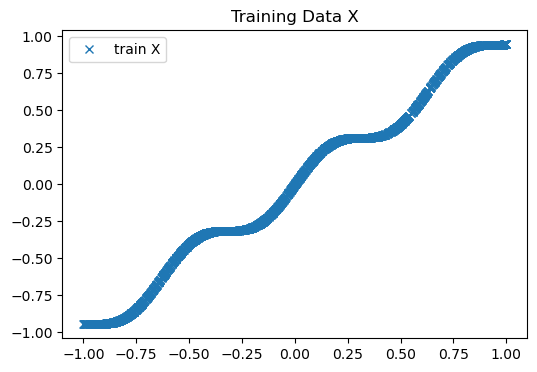

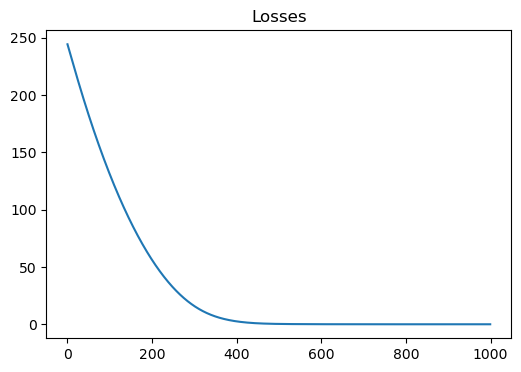

test data
        B_x       B_y       C_x       C_y     alpha
0 -0.349766 -0.314907  0.273307  0.313032 -5.000000
1 -0.365715 -0.316413  0.026158  0.052019 -3.888889
2  0.093530  0.174007  0.344262  0.314612 -2.777778
3 -0.261701 -0.311786  0.372111  0.317349 -1.666667
4  0.275395  0.313196 -0.659730 -0.690628 -0.555555
5  0.214699  0.298553 -0.009391 -0.018768  0.555555
6 -0.574326 -0.522919 -0.147053 -0.246551  1.666667
7  0.183209  0.279815 -0.409628 -0.328015  2.777778
8 -0.515565 -0.425230 -0.171933 -0.270832  3.888889
9 -0.225550 -0.303011  0.002103  0.004205  5.000000
resultat test of sum
      f($f^{-1}(B) + f^{-1}(C)$)                         B ⊕ C L^2 erreur  \
0   [-0.0041744057, 0.022533504]   [-0.005973406, 0.024084158]    2.4e-03   
1    [-0.0076849964, 0.01716237]   [-0.009304535, 0.018971033]    2.4e-03   
2    [0.0027647447, 0.033149727]   [0.0014547817, 0.034071326]    1.6e-03   
3   [-0.0010689218, 0.027280824]  [-0.0009502396, 0.026891507]    4.1e-04   
4    [-0.008

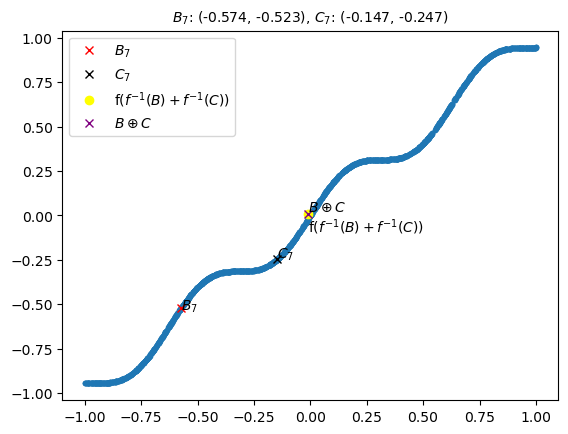

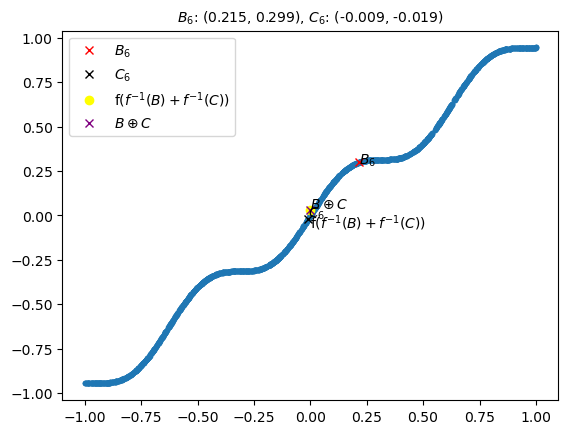

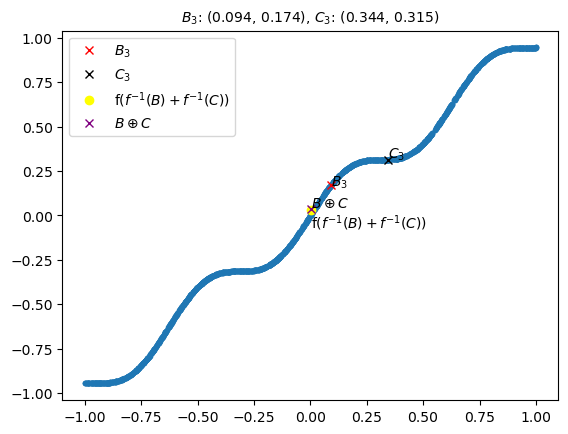

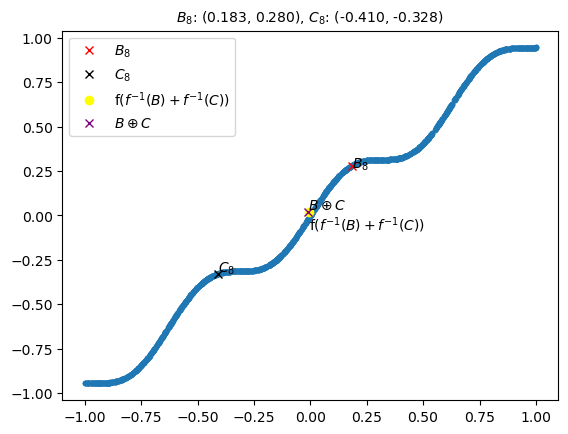

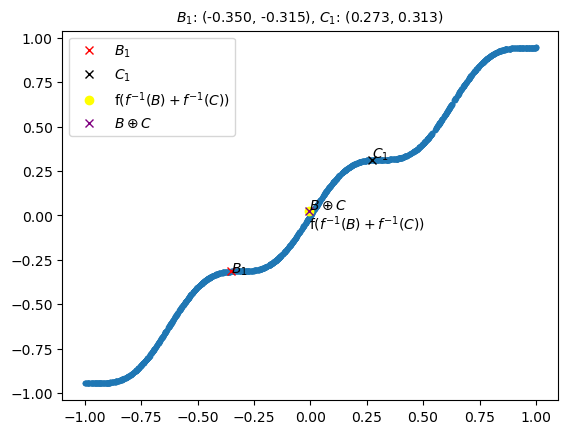

resultat test of dot
                f(α . f^{-1}(B))                         α ⊙ B L^2 erreur  \
0  [-0.020381598, -0.0019876938]   [-0.0050244033, 0.02347482]    3.0e-02   
1    [-0.003859656, 0.023248041]   [-0.0039916933, 0.02514584]    1.9e-03   
2   [-0.015891226, 0.0047994014]  [-0.0036160126, 0.025742054]    2.4e-02   
3    [-0.011449518, 0.011550615]  [-0.0050512105, 0.023430917]    1.3e-02   
4      [0.0019523036, 0.0320087]   [-0.005915299, 0.022046436]    1.3e-02   
5   [-0.0029385593, 0.024480665]  [-0.0039156675, 0.025267456]    1.3e-03   
6   [-0.0055982675, 0.020363033]   [-0.003086172, 0.026590403]    6.7e-03   
7   [-0.01885602, 4.3114647e-05]   [-0.0047263205, 0.02396188]    2.8e-02   
8    [-0.010518508, 0.012740884]  [-0.0029646829, 0.026793547]    1.6e-02   
9   [-0.0028224755, 0.024479818]   [-0.003908634, 0.025277808]    1.3e-03   

  inf erreur  
0    2.5e-02  
1    1.9e-03  
2    2.1e-02  
3    1.2e-02  
4    1.0e-02  
5    9.8e-04  
6    6.2e-03  
7    2.4e-0

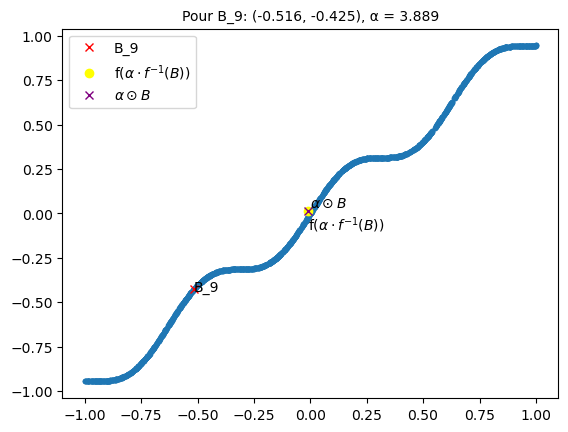

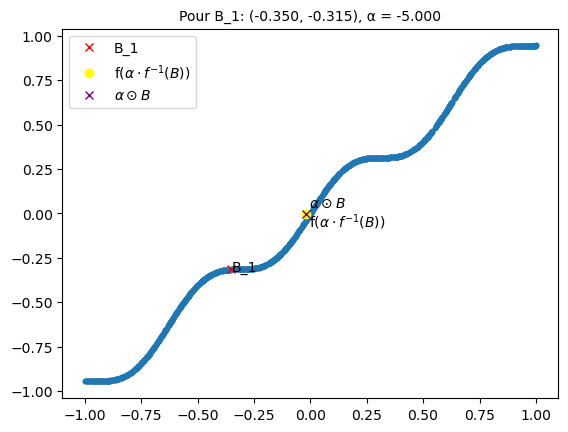

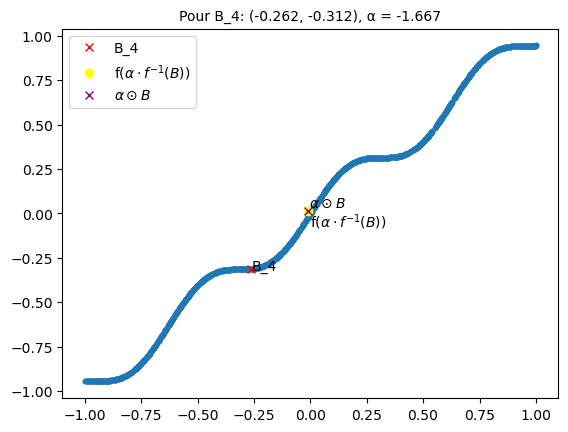

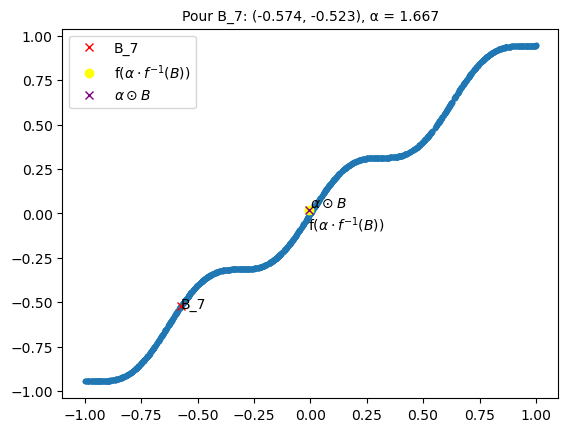

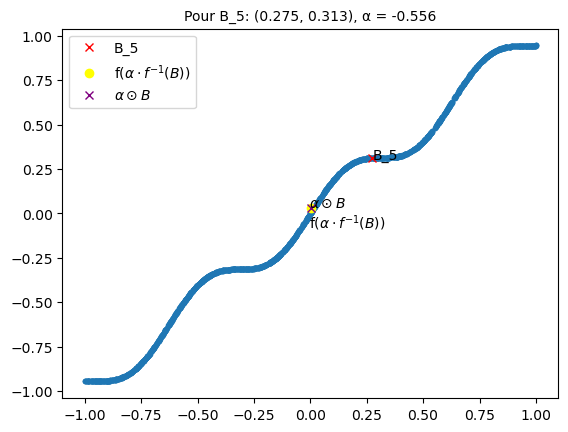

In [2]:
%run base.py --epoch 1000